# Task 2

#### The goal of this analysis is to evaluate the impact of a store trial conducted in Stores 77, 86, and 88. We will compare these trial stores to similar control stores to determine whether the trial led to a significant change in sales performance.

##### Steps for Analysis
-  Define Control Store Selection Criteria
>  Identify control stores that had similar sales patterns to each trial store before the trial period. Use a similarity metric such as Pearson correlation or Magnitude distance.
-  Compare Trial vs. Control Store Performance
>  Analyze total sales revenue, number of customers, and transactions per customer before and during the trial period.
-  Identify Key Drivers of Sales Change
>  Determine whether the sales change was due to
-  Summarize Findings & Provide Recommendations

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

In [2]:
qvi_data = pd.read_csv("QVI_data.csv")

In [3]:
qvi_data.head(2)

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream


In [4]:
qvi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [5]:
qvi_data.duplicated().sum()

1

In [6]:
# drop duplicates
qvi_data = qvi_data.drop_duplicates()

In [7]:
# convert DATE column into datetime format
qvi_data["DATE"] = pd.to_datetime(qvi_data["DATE"], format = "%Y-%m-%d")

##### create monthly metrics for each store before the trial period (Feb 2019) and then find stores that closely match the trial stores (77, 86, 88).

In [8]:
# create a YearMonth column in 'YYYYMM' format
qvi_data["YEARMONTH"] = qvi_data['DATE'].dt.to_period("M").astype(str).str.replace("-","").astype(int)

print(qvi_data[['DATE', 'YEARMONTH']].head())

        DATE  YEARMONTH
0 2018-10-17     201810
1 2018-09-16     201809
2 2019-03-07     201903
3 2019-03-08     201903
4 2018-11-02     201811


#### Compute Key Metrics for Each Store & Month
Total Sales Revenue → Sum of TOT_SALES</br>
Number of Customers → Unique count of LYLTY_CARD_NBR</br>
Transactions per Customer → Total transactions / Unique customers</br>
Chips per Transaction → Total PROD_QTY / Total transactions</br>
Average Price per Unit → Total TOT_SALES / Total PROD_QTY</br>

In [9]:
store_metrics = qvi_data.groupby(['STORE_NBR','YEARMONTH']).agg(TotalSales = ('TOT_SALES','sum'),
                                                               nCustomers = ('LYLTY_CARD_NBR','nunique'),
                                                               nTransactions = ('TXN_ID','nunique'),
                                                               nChips = ('PROD_QTY','sum')).reset_index()

store_metrics['nTxnPerCust'] = store_metrics['nTransactions']/store_metrics['nCustomers']
store_metrics['nChipsPerTxn'] = store_metrics['nChips'] / store_metrics['nTransactions']
store_metrics['avgPricePerUnit'] = store_metrics['TotalSales']/store_metrics['nChips']

store_metrics.head(3)

,STORE_NBR,YEARMONTH,TotalSales,nCustomers,nTransactions,nChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,52,62,1.061224,1.192308,3.337097
1,1,201808,176.1,42,43,54,1.023810,1.255814,3.261111
2,1,201809,278.8,59,62,75,1.050847,1.209677,3.717333


Filter stores with full observation periods before selecting control stores</br>
A store should be operational for atleast 12 months to show they are fully operational and consistent throughout the dataset</br>
Stores that were opened late or closed during this period should be excluded to ensure stable data

In [10]:
# number of months each store appears
store_month_count = store_metrics.groupby("STORE_NBR")["YEARMONTH"].nunique()
full_obs_stores = store_month_count[store_month_count == 12].index  # to just get store numbers

# filter pre-trial data for these stores
pre_trial_data = store_metrics[(store_metrics['YEARMONTH']<201902) & (store_metrics["STORE_NBR"].isin(full_obs_stores))]

pre_trial_data.head()

,STORE_NBR,YEARMONTH,TotalSales,nCustomers,nTransactions,nChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,52,62,1.061224,1.192308,3.337097
1,1,201808,176.1,42,43,54,1.023810,1.255814,3.261111
2,1,201809,278.8,59,62,75,1.050847,1.209677,3.717333
3,1,201810,188.1,44,45,58,1.022727,1.288889,3.243103
4,1,201811,192.6,46,47,57,1.021739,1.212766,3.378947


We need to compare each trial store (77, 86, 88) with all potential control stores to find the best match based on correlation.</br>
We need to write a function to calculate correlation (we'll use Pearson correlation)


In [11]:
def calculate_correlation(inputTable, metricCol, storeComparison):
    """
    - inputTable: DataFrame containing store metrics over time
    - metricCol: Column name of the metric to compare
    - storeComparison: Store number of the trial store
    """
    correlation_results = []

    trial_store_data = inputTable[inputTable["STORE_NBR"] == storeComparison][["YEARMONTH", metricCol]]

    control_stores = inputTable["STORE_NBR"].unique()
    control_stores = [store for store in control_stores if store != storeComparison]

    # loop through each potential control store
    for control_store in control_stores:
        control_store_data = inputTable[inputTable["STORE_NBR"] == control_store][["YEARMONTH", metricCol]]
        
        merged_data = trial_store_data.merge(control_store_data, on="YEARMONTH", suffixes=("_trial", "_control"))  # merge on YEARMONTH
        
        correlation = merged_data[metricCol + "_trial"].corr(merged_data[metricCol + "_control"])
        correlation_results.append({
            "Trial Store": storeComparison,
            "Control Store": control_store,
            "Correlation": correlation
        })

    return pd.DataFrame(correlation_results)

In [12]:
# find best control stores for trial store 77 based on Total Sales
correlation_table = calculate_correlation(pre_trial_data, "TotalSales", 77)
correlation_table.sort_values(by="Correlation", ascending=False).head()

,Trial Store,Control Store,Correlation
67,77,71,0.914106
220,77,233,0.903774
110,77,119,0.867664
15,77,17,0.842668
2,77,3,0.806644


write another function to measure the absolute difference between a trial store’s metric and each control store’s metric, then normalize the differences to a 0-1 scale to get a final similarity score for each control store.

In [13]:
def calculate_magnitude_distance(input_table, metric_col, store_comparison):
    
    distance_table = pd.DataFrame(columns=["Store1", "Store2", "YEARMONTH", "Measure"])   # create an empty dataframe to store results

    store_numbers = input_table["STORE_NBR"].unique()                                     # retrieve the list of all store numbers from the data 
    store_numbers = [store for store in store_numbers if store != store_comparison]

    for store in store_numbers:
        temp_df = pd.DataFrame({
            "Store1": store_comparison,
            "Store2": store,
            "YEARMONTH": input_table[input_table["STORE_NBR"] == store_comparison]["YEARMONTH"],
            "Measure": abs(
                input_table[input_table["STORE_NBR"] == store_comparison][metric_col].values -
                input_table[input_table["STORE_NBR"] == store][metric_col].values
            )
        })
        distance_table = pd.concat([distance_table, temp_df], ignore_index=True)         # append the result

   
    min_max_dist = distance_table.groupby(["Store1", "YEARMONTH"])["Measure"].agg(["min", "max"]).reset_index() 
    distance_table = distance_table.merge(min_max_dist, on=["Store1", "YEARMONTH"])
    
    distance_table["MagnitudeMeasure"] = 1 - (distance_table["Measure"] - distance_table["min"]) / (distance_table["max"] - distance_table["min"]) # normalize the Measure values using min-max scaling
    
    final_distance_table = distance_table.groupby(["Store1", "Store2"])["MagnitudeMeasure"].mean().reset_index()   # average MagnitudeMeasure across months for each trial store and each control store
    final_distance_table.rename(columns={"Store1": "Trial Store","Store2": "Control Store","MagnitudeMeasure": "MagMeasure"}, inplace=True)
    
    return final_distance_table

In [14]:
magnitude_table = calculate_magnitude_distance(pre_trial_data, "TotalSales", 77)
magnitude_table.sort_values(by="MagMeasure", ascending=False).head()

,Trial Store,Control Store,MagMeasure
220,77,233,0.987091
241,77,255,0.978526
49,77,53,0.977210
179,77,188,0.976961
122,77,131,0.976774


Now we have both the correlation score (Measures trend similarity) and the magnitude similarity scores (Measures absolute similarity), so we need to calculate a final ranking by taking an average of both scores.

Find the best control store for each trial store based on two key business metrics:
-  Total Sales per month
-  Number of Customers per month

#### for trial store 77

In [15]:
# define the trial store number
trial_store = 77

In [16]:
# compute correlation score
corr_nSales = calculate_correlation(pre_trial_data, "TotalSales",trial_store)
corr_nCustomers = calculate_correlation(pre_trial_data, "nCustomers", trial_store)

In [17]:
# compute magnitute similarity score
magnitude_nSales = calculate_magnitude_distance(pre_trial_data, "TotalSales", trial_store)
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_data, "nCustomers", trial_store)

In [18]:
# merge correlation and magnitude scores for each metric separately
score_nSales = corr_nSales.merge(magnitude_nSales, on =["Trial Store", "Control Store"])
score_nCustomers = corr_nCustomers.merge(magnitude_nCustomers, on=["Trial Store", "Control Store"])

In [19]:
# combine the correlation and magnitude similarity for each metric by taking a weighted average
corr_weight = 0.5 

score_nSales['scoreNSales'] = (corr_weight * score_nSales['Correlation'] + (1 - corr_weight) * score_nSales["MagMeasure"])
score_nCustomers['scoreNCust'] = (corr_weight * score_nCustomers['Correlation'] + (1 - corr_weight) * score_nCustomers["MagMeasure"])

In [20]:
score_nSales.head(3)

,Trial Store,Control Store,Correlation,MagMeasure,scoreNSales
0,77,1,0.075218,0.955061,0.515139
1,77,2,-0.263079,0.939318,0.338120
2,77,3,0.806644,0.354963,0.580803


In [21]:
score_nCustomers.head(3)

,Trial Store,Control Store,Correlation,MagMeasure,scoreNCust
0,77,1,0.322168,0.940321,0.631244
1,77,2,-0.572051,0.924638,0.176294
2,77,3,0.834207,0.345067,0.589637


In [22]:
# merge the Sales and Customers scores into one table
score_control = score_nSales.merge(score_nCustomers, on=["Trial Store", "Control Store"], suffixes=("_Sales", "_Cust"))

In [23]:
# take simple average of both the scores to get a final ranking
score_control["finalControlScore"] = (0.5 * score_control["scoreNSales"] +  0.5 * score_control["scoreNCust"])

In [24]:
score_control.head(3)

,Trial Store,Control Store,Correlation_Sales,MagMeasure_Sales,scoreNSales,Correlation_Cust,MagMeasure_Cust,scoreNCust,finalControlScore
0,77,1,0.075218,0.955061,0.515139,0.322168,0.940321,0.631244,0.573192
1,77,2,-0.263079,0.939318,0.338120,-0.572051,0.924638,0.176294,0.257207
2,77,3,0.806644,0.354963,0.580803,0.834207,0.345067,0.589637,0.58522


In [25]:
# pick the store with the highest final score
best_control_store =  score_control.sort_values(by = 'finalControlScore', ascending = False)
best_control_store.head()

,Trial Store,Control Store,Correlation_Sales,MagMeasure_Sales,scoreNSales,Correlation_Cust,MagMeasure_Cust,scoreNCust,finalControlScore
220,77,233,0.903774,0.987091,0.945433,0.990358,0.992773,0.991566,0.968499
38,77,41,0.783232,0.966917,0.875075,0.844219,0.974639,0.909429,0.892252
15,77,17,0.842668,0.882314,0.862491,0.747308,0.962495,0.854902,0.858696
240,77,254,0.577108,0.924468,0.750788,0.916208,0.937131,0.92667,0.838729
107,77,115,0.689159,0.934576,0.811868,0.718882,0.965916,0.842399,0.827133


In [26]:
# pick the top one
control_store = best_control_store.groupby("Trial Store").first()
control_store

,Control Store,Correlation_Sales,MagMeasure_Sales,scoreNSales,Correlation_Cust,MagMeasure_Cust,scoreNCust,finalControlScore
Trial Store,,,,,,,,
77,233,0.903774,0.987091,0.945433,0.990358,0.992773,0.991566,0.968499


In [27]:
pre_trial_sales = store_metrics[store_metrics["YEARMONTH"] < 201902].copy()
# extract the control store number
control_store_nbr = control_store.loc[trial_store, "Control Store"]
pre_trial_sales["Store_type"] = pre_trial_sales["STORE_NBR"].map(lambda x: "Trial" if x == trial_store else 
                                                                 "Control" if x == control_store_nbr else None)

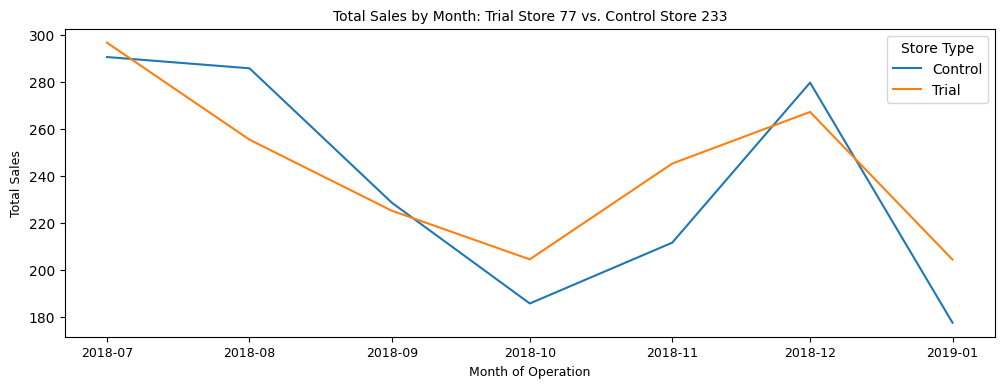

In [28]:
# Plot the Sales Trends
sales_trends = pre_trial_sales.dropna(subset=["Store_type"]).groupby(["YEARMONTH", "Store_type"])["TotalSales"].mean().reset_index()
sales_trends["TransactionMonth"] = pd.to_datetime(sales_trends["YEARMONTH"].astype(str), format="%Y%m")

plt.figure(figsize=(12, 4))
sns.lineplot(data=sales_trends, x="TransactionMonth", y="TotalSales", hue="Store_type")
plt.xlabel("Month of Operation", fontsize = 9)
plt.ylabel("Total Sales", fontsize = 9)
plt.title(f"Total Sales by Month: Trial Store {trial_store} vs. Control Store {control_store_nbr}", fontsize = 10)
plt.xticks(fontsize =9)
plt.legend(title="Store Type")
plt.show()

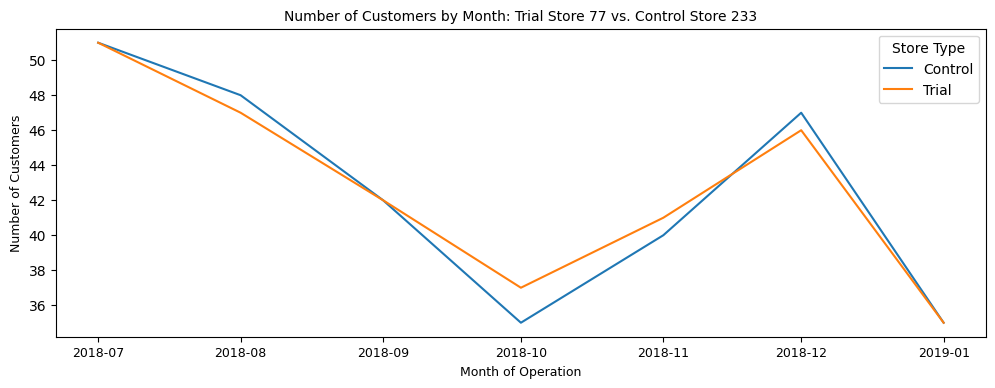

In [29]:
# Plotting customer trends
customer_trends = pre_trial_sales.dropna(subset=["Store_type"]).groupby(["YEARMONTH", "Store_type"])["nCustomers"].mean().reset_index()
customer_trends["TransactionMonth"] = pd.to_datetime(customer_trends["YEARMONTH"].astype(str), format ="%Y%m")

plt.figure(figsize=(12, 4))
sns.lineplot(data=customer_trends, x="TransactionMonth", y="nCustomers", hue="Store_type")
plt.xlabel("Month of Operation", fontsize = 9)
plt.ylabel("Number of Customers", fontsize = 9)
plt.title(f"Number of Customers by Month: Trial Store {trial_store} vs. Control Store {control_store_nbr}", fontsize = 10)
plt.xticks(fontsize =9)
plt.legend(title="Store Type")
plt.show()

But before we compare the sales trends of the Trial Store and the Control Store, we need to adjust for pre-existing differences in their sales levels.

In [30]:
# get pre-trial total sales 
trial_store_pre_sales = pre_trial_sales[(pre_trial_sales["STORE_NBR"] == trial_store) & (pre_trial_sales["YEARMONTH"] < 201902)]["TotalSales"].sum()
control_store_pre_sales = pre_trial_sales[(pre_trial_sales["STORE_NBR"] == control_store_nbr) & (pre_trial_sales["YEARMONTH"] < 201902)]["TotalSales"].sum()

In [31]:
scaling_factor = trial_store_pre_sales/control_store_pre_sales
print("Scaling Factor for Control Store:", scaling_factor)

Scaling Factor for Control Store: 1.023617303289553


In [32]:
# adjust the control store sales
measure_over_time_sales = store_metrics.copy()

# scale control store sales
measure_over_time_sales.loc[measure_over_time_sales["STORE_NBR"] == control_store_nbr, "ScaledControlSales"] = measure_over_time_sales["TotalSales"] * scaling_factor

In [33]:
measure_over_time_sales.head()

,STORE_NBR,YEARMONTH,TotalSales,nCustomers,nTransactions,nChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,ScaledControlSales
0,1,201807,206.9,49,52,62,1.061224,1.192308,3.337097,NaN
1,1,201808,176.1,42,43,54,1.023810,1.255814,3.261111,NaN
2,1,201809,278.8,59,62,75,1.050847,1.209677,3.717333,NaN
3,1,201810,188.1,44,45,58,1.022727,1.288889,3.243103,NaN
4,1,201811,192.6,46,47,57,1.021739,1.212766,3.378947,NaN


In [34]:
# calculate the percentage difference
percentage_diff = measure_over_time_sales.copy()

In [35]:
# merge trial store sales and scaled control sales
percentage_diff = measure_over_time_sales[(measure_over_time_sales["STORE_NBR"] == trial_store) | 
                                          (measure_over_time_sales["STORE_NBR"] == control_store_nbr)
                                         ][["YEARMONTH", "STORE_NBR", "TotalSales", "ScaledControlSales"]]

In [36]:
# get separate columns for Trial and Control Sales
percentage_diff = percentage_diff.pivot(index="YEARMONTH", columns="STORE_NBR", values=["TotalSales", "ScaledControlSales"]).reset_index()
# rename columns
percentage_diff.columns = ['YEARMONTH', 'TrialSales', 'ControlSales', 'TrialScaledSales', 'ScaledControlSales']
percentage_diff = percentage_diff.drop(columns=['TrialScaledSales'])

In [37]:
# compute percentage difference
percentage_diff["PercentageDiff"] = ((percentage_diff["TrialSales"] - percentage_diff["ScaledControlSales"]) / 
                                     ((percentage_diff["TrialSales"] + percentage_diff["ScaledControlSales"]) / 2))

In [38]:
# calculate the standard deviation of the percentage difference before the trial
pre_trial_std_dev = percentage_diff[percentage_diff["YEARMONTH"] < 201902]["PercentageDiff"].std()
print("Standard Deviation of Percentage Difference (Pre-Trial):", pre_trial_std_dev)

Standard Deviation of Percentage Difference (Pre-Trial): 0.09877934078976909


In [39]:
# compute T-values for Trial Period to check for significant change
percentage_diff["tValue"] = percentage_diff["PercentageDiff"] / pre_trial_std_dev

In [40]:
percentage_diff

,YEARMONTH,TrialSales,ControlSales,ScaledControlSales,PercentageDiff,tValue
0,201807,296.8,290.7,297.565550,-0.002576,-0.026079
1,201808,255.5,285.9,292.652187,-0.135554,-1.372294
2,201809,225.2,228.6,233.998916,-0.038323,-0.387965
3,201810,204.5,185.7,190.085733,0.073060,0.739631
4,201811,245.3,211.6,216.597421,0.124281,1.258170
5,201812,267.3,279.8,286.408121,-0.069019,-0.698716
6,201901,204.4,177.5,181.692071,0.117630,1.190832
7,201902,235.0,244.0,249.762622,-0.060907,-0.616593
8,201903,278.5,199.1,203.802205,0.309755,3.135829
9,201904,263.5,158.6,162.345704,0.475075,4.809456


In [41]:
from scipy.stats import t

# get the 95th percentile of the t-distribution
degrees_of_freedom = 6
t_critical = t.ppf(0.95, degrees_of_freedom)
print("95th Percentile of t-distribution:", t_critical)

95th Percentile of t-distribution: 1.9431802805153018


In [42]:
# check if the trial period's t-values exceed the critical value
percentage_diff["Significance"] = percentage_diff["tValue"].apply(
    lambda x: "Significant" if x > t_critical else "Not Significant")

# filter only trial months 
trial_results = percentage_diff[(percentage_diff["YEARMONTH"] >= 201902) & (percentage_diff["YEARMONTH"] <= 201904)]
trial_results[["YEARMONTH", "PercentageDiff", "tValue", "Significance"]]

,YEARMONTH,PercentageDiff,tValue,Significance
7,201902,-0.060907,-0.616593,Not Significant
8,201903,0.309755,3.135829,Significant
9,201904,0.475075,4.809456,Significant


##### Insights: 
-  February 2019 : Sales at the Trial store were 6.09% lower than the scaled control store. However, this difference was not statistically significant (t-value = -0.62 < 1.94).This supports the null hypothesis that the trial had not yet impacted customer behavior.
-  March 2019 : Sales increased by +30.9% compared to the scaled control store, and the t-value of 3.14 exceeded the significance threshold of 1.94. This indicates a statistically significant improvement and positive purchasing behavior.
-  April 2019 : The trial store saw an even greater sales uplift of +47.1% relative to the control, with a highly significant t-value of 4.8.
- Trial Store 77 seems to have been successful in boosting chip sales. The strogest impact was in April (+47.5%), showing a growing positive trend.

##### Let us visualize if the trial actually worked by looking at a line graph

In [43]:
measureOverTimeSales = measure_over_time_sales.copy()
measureOverTimeSales["Store_type"] = measureOverTimeSales["STORE_NBR"].apply(lambda x: "Trial" if x == trial_store 
                                                                             else "Control" if x == control_store_nbr else None)
# filter only the Control and Trial Store
pastSales = measureOverTimeSales[measureOverTimeSales["Store_type"].notna()].copy()
pastSales['Store_type'].unique()

array(['Trial', 'Control'], dtype=object)

In [44]:
pastSales.head(3)

,STORE_NBR,YEARMONTH,TotalSales,nCustomers,nTransactions,nChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,ScaledControlSales,Store_type
880,77,201807,296.8,51,55,84,1.078431,1.527273,3.533333,NaN,Trial
881,77,201808,255.5,47,48,74,1.021277,1.541667,3.452703,NaN,Trial
882,77,201809,225.2,42,44,70,1.047619,1.590909,3.217143,NaN,Trial


We need to create two extra versions of the Control Store’s sales:
-  Control 95% Confidence Interval → Upper Bound (Control Sales × (1 + 2 × Std Dev))
-  Control 5% Confidence Interval → Lower Bound (Control Sales × (1 - 2 × Std Dev))

In [45]:
# create Upper Bound 
pastSales_Control95 = pastSales[pastSales["Store_type"] == "Control"].copy()
control_sales_mean = pastSales_Control95["ScaledControlSales"].mean()
pastSales_Control95["ScaledControlSales"] = pastSales_Control95["ScaledControlSales"] * (1 + 2 * pre_trial_std_dev)
pastSales_Control95["Store_type"] = "Control 95% CI"

# create Lower Bound 
pastSales_Control5 = pastSales[pastSales["Store_type"] == "Control"].copy()
pastSales_Control5["ScaledControlSales"] = pastSales_Control5["ScaledControlSales"] * (1 - 2 * pre_trial_std_dev)
pastSales_Control5["Store_type"] = "Control 5% CI"

# concatenate all datasets
trialAssessment = pd.concat([pastSales, pastSales_Control95, pastSales_Control5])

In [46]:
trialAssessment = trialAssessment[trialAssessment["YEARMONTH"].isin([201902, 201903, 201904])]

In [47]:
# TransactionMonth in datetime format
trialAssessment["TransactionMonth"] = pd.to_datetime(trialAssessment["YEARMONTH"].astype(str), format="%Y%m")

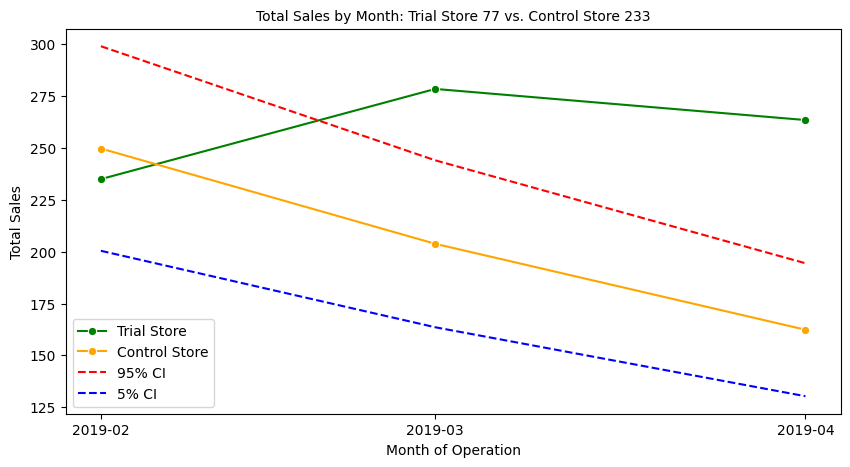

In [48]:
plt.figure(figsize=(10, 5))

# Line chart for Trial and Control Sales
sns.lineplot(data=trialAssessment[trialAssessment["Store_type"] == "Trial"], 
             x="TransactionMonth", y="TotalSales", color="green", marker='o', label="Trial Store")

sns.lineplot(data=trialAssessment[trialAssessment["Store_type"] == "Control"], 
             x="TransactionMonth", y="ScaledControlSales", color="orange", marker='o', label="Control Store")

# Line chart for 95% and 5% CI (using ScaledControlSales)
sns.lineplot(data=trialAssessment[trialAssessment["Store_type"] == "Control 95% CI"], 
             x="TransactionMonth", y="ScaledControlSales", color="red", linestyle="dashed", label="95% CI")

sns.lineplot(data=trialAssessment[trialAssessment["Store_type"] == "Control 5% CI"], 
             x="TransactionMonth", y="ScaledControlSales", color="blue", linestyle="dashed", label="5% CI")

plt.xlabel("Month of Operation")
plt.ylabel("Total Sales")
plt.title(f"Total Sales by Month: Trial Store {trial_store} vs. Control Store {control_store_nbr}", fontsize = 10)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(trialAssessment["TransactionMonth"].unique())
plt.legend()
plt.show()

##### Insights:
-  In March and April, the Trial Store's sales were clearly higher than the Control Store's sales and even above the 95% confidence line this suggests that the trial likely had a positive effect.
-  The Trial Store line crosses above the red dashed 95% CI line, meaning the increase is unlikely to be random and is statistically significant.

##### Analyzing Customer Counts

In [49]:
# Get total pre-trial customer counts for Trial and Control Stores
trial_store_pre_customers = pre_trial_sales[(pre_trial_sales["STORE_NBR"] == trial_store) & (pre_trial_sales["YEARMONTH"] < 201902)]["nCustomers"].sum()

control_store_pre_customers = pre_trial_sales[(pre_trial_sales["STORE_NBR"] == control_store_nbr) & (pre_trial_sales["YEARMONTH"] < 201902)]["nCustomers"].sum()

# compute Scaling Factor
scalingFactorForControlCust = trial_store_pre_customers / control_store_pre_customers
print("Scaling Factor for Control Store:", scalingFactorForControlCust)

Scaling Factor for Control Store: 1.0033557046979866


In [50]:
# apply Scaling Factor to Control Store
measureOverTimeCusts = measure_over_time_sales.copy()
measureOverTimeCusts.loc[measureOverTimeCusts["STORE_NBR"] == control_store_nbr, "ScaledControlCustomers"] = measureOverTimeCusts["nCustomers"] * scalingFactorForControlCust

In [51]:
measureOverTimeCusts.head(3)

,STORE_NBR,YEARMONTH,TotalSales,nCustomers,nTransactions,nChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,ScaledControlSales,ScaledControlCustomers
0,1,201807,206.9,49,52,62,1.061224,1.192308,3.337097,NaN,NaN
1,1,201808,176.1,42,43,54,1.023810,1.255814,3.261111,NaN,NaN
2,1,201809,278.8,59,62,75,1.050847,1.209677,3.717333,NaN,NaN


In [52]:
# calculate the percentage differnce
percentage_diff_customers = measureOverTimeCusts.copy()

# merge trial store and scaled control customers
percentage_diff_customers = measureOverTimeCusts[(measureOverTimeCusts["STORE_NBR"] == trial_store) | 
                                          (measureOverTimeCusts["STORE_NBR"] == control_store_nbr)
                                         ][["YEARMONTH", "STORE_NBR", "nCustomers", "ScaledControlCustomers"]]

In [53]:
percentage_diff_customers.head()

,YEARMONTH,STORE_NBR,nCustomers,ScaledControlCustomers
880,201807,77,51,NaN
881,201808,77,47,NaN
882,201809,77,42,NaN
883,201810,77,37,NaN
884,201811,77,41,NaN


In [54]:
percentage_diff_customers = percentage_diff_customers.pivot(index="YEARMONTH", columns="STORE_NBR", values =
                                                            ["nCustomers", "ScaledControlCustomers"]).reset_index()

In [55]:
percentage_diff_customers.columns = ['YEARMONTH', 'TrialCustomers', 'ControlCustomers', 'TrialScaledCustomers', 'ScaledControlCustomers']
percentage_diff_customers = percentage_diff_customers.drop(columns=['TrialScaledCustomers'])

In [56]:
# compute percentage difference
percentage_diff_customers["PercentageDiff"] = ((percentage_diff_customers["TrialCustomers"] - percentage_diff_customers["ScaledControlCustomers"]) / 
                                               ((percentage_diff_customers["TrialCustomers"] + percentage_diff_customers["ScaledControlCustomers"]) / 2))

In [57]:
percentage_diff_customers.head()

,YEARMONTH,TrialCustomers,ControlCustomers,ScaledControlCustomers,PercentageDiff
0,201807,51.0,51.0,51.171141,-0.003350
1,201808,47.0,48.0,48.161074,-0.024402
2,201809,42.0,42.0,42.140940,-0.003350
3,201810,37.0,35.0,35.117450,0.052208
4,201811,41.0,40.0,40.134228,0.021342


In [58]:
# calculate the standard deviation of the percentage difference before the trial
pre_trial_std_dev_customers = percentage_diff_customers[percentage_diff_customers["YEARMONTH"] < 201902]["PercentageDiff"].std()
print("Standard Deviation of Percentage Difference (Pre-Trial):", pre_trial_std_dev_customers)

Standard Deviation of Percentage Difference (Pre-Trial): 0.02707726429609864


In [59]:
# compute T-values for Trial Period to check for significant change
percentage_diff_customers["tValue"] = percentage_diff_customers["PercentageDiff"] / pre_trial_std_dev_customers

In [60]:
# lets decide significance level
from scipy.stats import t

degrees_of_freedom = 6  
t_critical_customers = t.ppf(0.95, degrees_of_freedom)
print("95th Percentile of t-distribution (Customers):", t_critical_customers)

95th Percentile of t-distribution (Customers): 1.9431802805153018


In [61]:
# check if the trial period's t-values exceed the critical value
percentage_diff_customers["Significance"] = percentage_diff_customers["tValue"].apply(lambda x: "Significant" if 
                                                                                      x > t_critical_customers else "Not Significant")
# filter trial months 
trial_results_customers = percentage_diff_customers[(percentage_diff_customers["YEARMONTH"] >= 201902) & 
                                                    (percentage_diff_customers["YEARMONTH"] <= 201904)]
trial_results_customers[["YEARMONTH", "PercentageDiff", "tValue", "Significance"]]

,YEARMONTH,PercentageDiff,tValue,Significance
7,201902,-0.003350,-0.123723,Not Significant
8,201903,0.218913,8.084749,Significant
9,201904,0.438370,16.189615,Significant


##### Insights:
-  February 2019 :  Customer counts at the trial store were almost the same as the control, with only a -0.34% decrease. The t-value (-0.12) was well below the critical threshold (1.94), indicating no statistically significant difference.
-  March 2019 : There was +21.89% increase in customer numbers at the trial store compared to the scaled control. With a high t-value of 8.08, this change is statistically significant, indicating a strong positive impact from the trial beginning to take effect in terms of attracting more customers.
-  April 2019 : Customer growth accelerated with +43.84% increase over the control store. The t-value soared to 16.19, far exceeding the threshold for significance. This confirms the increase is not due to chance, but likely driven by the trial changes.
-  Trial store 77 from March onward was statistically significant thus was successful in driving more customers, by April 2019 the impact was even stronger.

In [62]:
measure_over_time_cust = measureOverTimeCusts.copy()
measure_over_time_cust["Store_type"] = measure_over_time_cust["STORE_NBR"].apply(lambda x: "Trial" if x == trial_store
                                                                                else "Control" if x == control_store_nbr else None)

# filter only the Control and Trial Store
pastCusts = measure_over_time_cust[measure_over_time_cust["Store_type"].notna()].copy()
pastCusts['Store_type'].unique()

array(['Trial', 'Control'], dtype=object)

In [63]:
pastCusts.head(3)

,STORE_NBR,YEARMONTH,TotalSales,nCustomers,nTransactions,nChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,ScaledControlSales,ScaledControlCustomers,Store_type
880,77,201807,296.8,51,55,84,1.078431,1.527273,3.533333,NaN,NaN,Trial
881,77,201808,255.5,47,48,74,1.021277,1.541667,3.452703,NaN,NaN,Trial
882,77,201809,225.2,42,44,70,1.047619,1.590909,3.217143,NaN,NaN,Trial


We need to create two extra versions of the Control Store’s customer counts:
-  Control 95% Confidence Interval → Upper Bound (Control Customer × (1 + 2 × Std Dev))
-  Control 5% Confidence Interval → Lower Bound (Control Customer × (1 - 2 × Std Dev))

In [64]:
# create upper bound
pastCusts_Control95 = pastCusts[pastCusts["Store_type"] == "Control"].copy()
pastCusts_Control95["ScaledControlCustomers"] *= (1 + 2 * pre_trial_std_dev_customers)
pastCusts_Control95["Store_type"] = "Control 95% CI"

# create Lower Bound 
pastCusts_Control5 = pastCusts[pastCusts["Store_type"] == "Control"].copy()
pastCusts_Control5["ScaledControlCustomers"] *= (1 - 2 * pre_trial_std_dev_customers)
pastCusts_Control5["Store_type"] = "Control 5% CI"

# concatenate all datasets
trial_Assessment = pd.concat([pastCusts, pastCusts_Control95, pastCusts_Control5])

trial_Assessment = trial_Assessment[trial_Assessment["YEARMONTH"].isin([201902, 201903, 201904])]

In [65]:
# TransactionMonth in datetime format
trial_Assessment["TransactionMonth"] = pd.to_datetime(trial_Assessment["YEARMONTH"].astype(str), format="%Y%m")

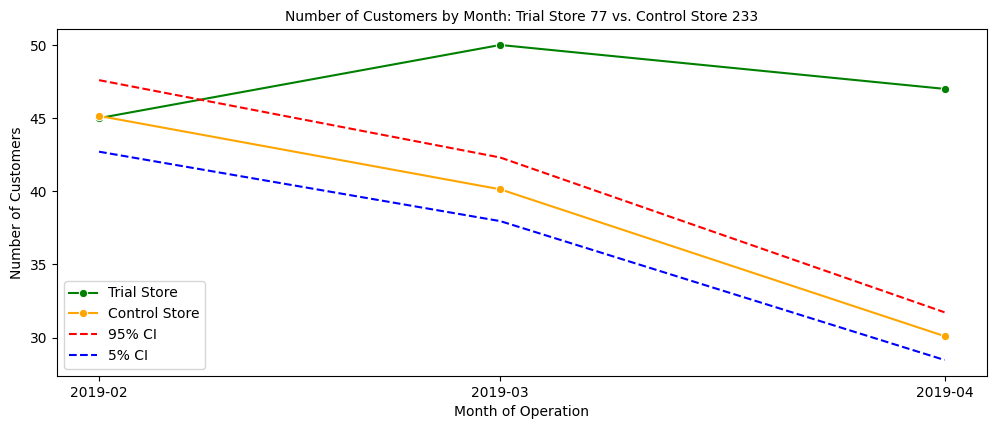

In [66]:

plt.figure(figsize=(12, 4.5))

# Line chart for Trial and Control store
sns.lineplot(data=trial_Assessment[trial_Assessment["Store_type"] == "Trial"], 
             x="TransactionMonth", y="nCustomers", color="green", marker='o', label="Trial Store")

sns.lineplot(data=trial_Assessment[trial_Assessment["Store_type"] == "Control"], 
             x="TransactionMonth", y="ScaledControlCustomers", color="orange", marker='o', label="Control Store")

# Line chart for 95% and 5% CI 
sns.lineplot(data=trial_Assessment[trial_Assessment["Store_type"] == "Control 95% CI"], 
             x="TransactionMonth", y="ScaledControlCustomers", color="red", linestyle="dashed", label="95% CI")

sns.lineplot(data=trial_Assessment[trial_Assessment["Store_type"] == "Control 5% CI"], 
             x="TransactionMonth", y="ScaledControlCustomers", color="blue", linestyle="dashed", label="5% CI")

plt.xlabel("Month of Operation")
plt.ylabel("Number of Customers")
plt.title(f"Number of Customers by Month: Trial Store {trial_store} vs. Control Store {control_store_nbr}", fontsize = 10)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(trial_Assessment["TransactionMonth"].unique())
plt.legend()
plt.show()

##### Insights:
-  The Trial and Control stores had a similar number of customers for Feb 2019 and then there is a sharp increase in customer numbers, going above the 95% confidence interval for March and April 2019 suggesting that this increase is statistically significant and not just random.

#### for trial store 86

In [67]:
# define the trial store number
trial_store = 86

In [68]:
# compute correlation score
corr_nSales = calculate_correlation(pre_trial_data, "TotalSales",trial_store)
corr_nCustomers = calculate_correlation(pre_trial_data, "nCustomers", trial_store)

In [69]:
# compute magnitute similarity score
magnitude_nSales = calculate_magnitude_distance(pre_trial_data, "TotalSales", trial_store)
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_data, "nCustomers", trial_store)

In [70]:
# merge correlation and magnitude scores for each metric separately
score_nSales = corr_nSales.merge(magnitude_nSales, on =["Trial Store", "Control Store"])
score_nCustomers = corr_nCustomers.merge(magnitude_nCustomers, on=["Trial Store", "Control Store"])

In [71]:
# combine the correlation and magnitude similarity for each metric by taking a weighted average
corr_weight = 0.5 

score_nSales['scoreNSales'] = (corr_weight * score_nSales['Correlation'] + (1 - corr_weight) * score_nSales["MagMeasure"])
score_nCustomers['scoreNCust'] = (corr_weight * score_nCustomers['Correlation'] + (1 - corr_weight) * score_nCustomers["MagMeasure"])

In [72]:
score_nSales.head(3)

,Trial Store,Control Store,Correlation,MagMeasure,scoreNSales
0,86,1,0.445632,0.220565,0.333099
1,86,2,-0.403835,0.179640,-0.112097
2,86,3,-0.261284,0.762894,0.250805


In [73]:
score_nCustomers.head(3)

,Trial Store,Control Store,Correlation,MagMeasure,scoreNCust
0,86,1,0.485831,0.444597,0.465214
1,86,2,-0.086161,0.38062,0.14723
2,86,3,-0.353786,0.91185,0.279032


In [74]:
# merge the Sales and Customers scores into one table
score_control = score_nSales.merge(score_nCustomers, on=["Trial Store", "Control Store"], suffixes=("_Sales", "_Cust"))

In [75]:
# take simple average of both the scores to get a final ranking
score_control["finalControlScore"] = (0.5 * score_control["scoreNSales"] +  0.5 * score_control["scoreNCust"])

In [76]:
score_control.head(3)

,Trial Store,Control Store,Correlation_Sales,MagMeasure_Sales,scoreNSales,Correlation_Cust,MagMeasure_Cust,scoreNCust,finalControlScore
0,86,1,0.445632,0.220565,0.333099,0.485831,0.444597,0.465214,0.399156
1,86,2,-0.403835,0.179640,-0.112097,-0.086161,0.38062,0.14723,0.017566
2,86,3,-0.261284,0.762894,0.250805,-0.353786,0.91185,0.279032,0.264919


In [77]:
# pick the store with the highest final score
best_control_store =  score_control.sort_values(by = 'finalControlScore', ascending = False)
best_control_store.head()

,Trial Store,Control Store,Correlation_Sales,MagMeasure_Sales,scoreNSales,Correlation_Cust,MagMeasure_Cust,scoreNCust,finalControlScore
146,86,155,0.877882,0.964782,0.921332,0.942876,0.985037,0.963956,0.942644
101,86,109,0.788300,0.963810,0.876055,0.770778,0.96594,0.868359,0.872207
106,86,114,0.734415,0.921021,0.827718,0.855339,0.935508,0.895424,0.861571
129,86,138,0.759864,0.925434,0.842649,0.749701,0.928031,0.838866,0.840757
212,86,225,0.617533,0.958060,0.787796,0.733791,0.967367,0.850579,0.819188


In [78]:
# pick the top one
control_store = best_control_store.groupby("Trial Store").first()
control_store

,Control Store,Correlation_Sales,MagMeasure_Sales,scoreNSales,Correlation_Cust,MagMeasure_Cust,scoreNCust,finalControlScore
Trial Store,,,,,,,,
86,155,0.877882,0.964782,0.921332,0.942876,0.985037,0.963956,0.942644


In [79]:
pre_trial_sales = store_metrics[store_metrics["YEARMONTH"] < 201902].copy()
# extract the control store number
control_store_nbr = control_store.loc[trial_store, "Control Store"]
pre_trial_sales["Store_type"] = pre_trial_sales["STORE_NBR"].map(lambda x: "Trial" if x == trial_store else 
                                                                 "Control" if x == control_store_nbr else None)

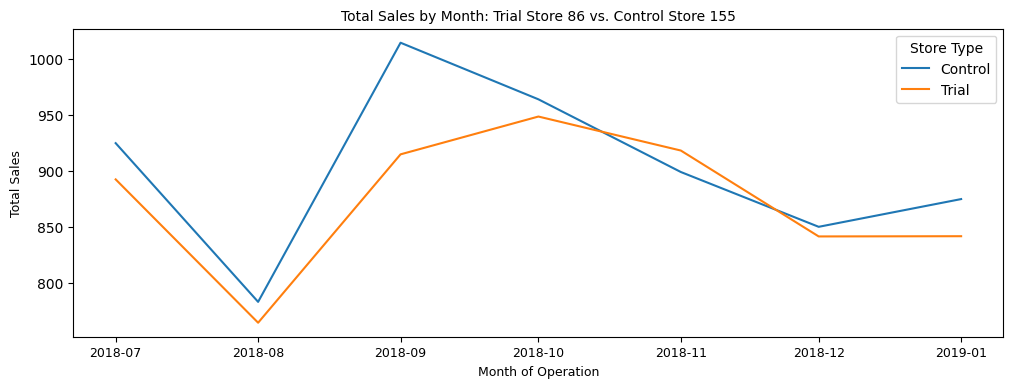

In [80]:
# Plot the Sales Trends
sales_trends = pre_trial_sales.dropna(subset=["Store_type"]).groupby(["YEARMONTH", "Store_type"])["TotalSales"].mean().reset_index()
sales_trends["TransactionMonth"] = pd.to_datetime(sales_trends["YEARMONTH"].astype(str), format="%Y%m")

plt.figure(figsize=(12, 4))
sns.lineplot(data=sales_trends, x="TransactionMonth", y="TotalSales", hue="Store_type")
plt.xlabel("Month of Operation", fontsize = 9)
plt.ylabel("Total Sales", fontsize = 9)
plt.title(f"Total Sales by Month: Trial Store {trial_store} vs. Control Store {control_store_nbr}", fontsize = 10)
plt.xticks(fontsize =9)
plt.legend(title="Store Type")
plt.show()

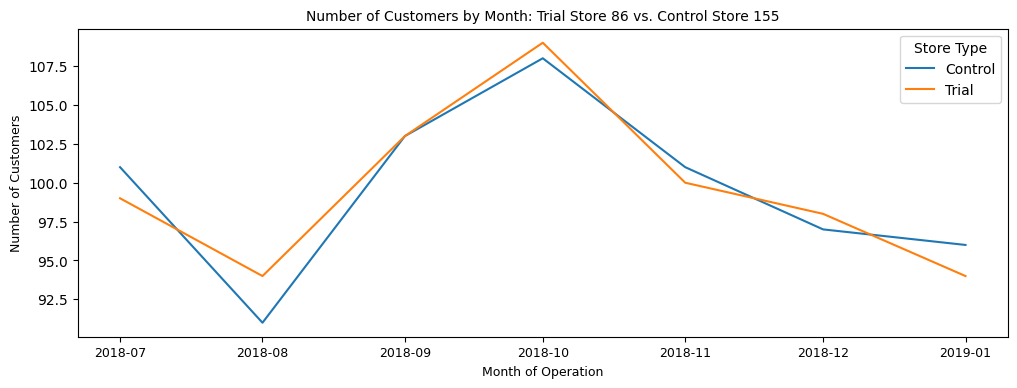

In [81]:
# Plotting customer trends
customer_trends = pre_trial_sales.dropna(subset=["Store_type"]).groupby(["YEARMONTH", "Store_type"])["nCustomers"].mean().reset_index()
customer_trends["TransactionMonth"] = pd.to_datetime(customer_trends["YEARMONTH"].astype(str), format ="%Y%m")

plt.figure(figsize=(12, 4))
sns.lineplot(data=customer_trends, x="TransactionMonth", y="nCustomers", hue="Store_type")
plt.xlabel("Month of Operation", fontsize = 9)
plt.ylabel("Number of Customers", fontsize = 9)
plt.title(f"Number of Customers by Month: Trial Store {trial_store} vs. Control Store {control_store_nbr}", fontsize = 10)
plt.xticks(fontsize =9)
plt.legend(title="Store Type")
plt.show()

But before we compare the sales trends of the Trial Store and the Control Store, we need to adjust for pre-existing differences in their sales levels.

In [82]:
# get pre-trial total sales 
trial_store_pre_sales = pre_trial_sales[(pre_trial_sales["STORE_NBR"] == trial_store) & (pre_trial_sales["YEARMONTH"] < 201902)]["TotalSales"].sum()
control_store_pre_sales = pre_trial_sales[(pre_trial_sales["STORE_NBR"] == control_store_nbr) & (pre_trial_sales["YEARMONTH"] < 201902)]["TotalSales"].sum()

In [83]:
scaling_factor = trial_store_pre_sales/control_store_pre_sales
print("Scaling Factor for Control Store:", scaling_factor)

Scaling Factor for Control Store: 0.9700651481287743


In [84]:
# adjust the control store sales
measure_over_time_sales = store_metrics.copy()

# scale control store sales
measure_over_time_sales.loc[measure_over_time_sales["STORE_NBR"] == control_store_nbr, "ScaledControlSales"] = measure_over_time_sales["TotalSales"] * scaling_factor

In [85]:
measure_over_time_sales.head()

,STORE_NBR,YEARMONTH,TotalSales,nCustomers,nTransactions,nChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,ScaledControlSales
0,1,201807,206.9,49,52,62,1.061224,1.192308,3.337097,NaN
1,1,201808,176.1,42,43,54,1.023810,1.255814,3.261111,NaN
2,1,201809,278.8,59,62,75,1.050847,1.209677,3.717333,NaN
3,1,201810,188.1,44,45,58,1.022727,1.288889,3.243103,NaN
4,1,201811,192.6,46,47,57,1.021739,1.212766,3.378947,NaN


In [86]:
# calculate the percentage difference
percentage_diff = measure_over_time_sales.copy()

In [87]:
# merge trial store sales and scaled control sales
percentage_diff = measure_over_time_sales[(measure_over_time_sales["STORE_NBR"] == trial_store) | 
                                          (measure_over_time_sales["STORE_NBR"] == control_store_nbr)
                                         ][["YEARMONTH", "STORE_NBR", "TotalSales", "ScaledControlSales"]]

In [88]:
# get separate columns for Trial and Control Sales
percentage_diff = percentage_diff.pivot(index="YEARMONTH", columns="STORE_NBR", values=["TotalSales", "ScaledControlSales"]).reset_index()

percentage_diff.columns = ['YEARMONTH', 'TrialSales', 'ControlSales', 'TrialScaledSales', 'ScaledControlSales']
percentage_diff = percentage_diff.drop(columns=['TrialScaledSales'])

In [89]:
# compute percentage difference
percentage_diff["PercentageDiff"] = ((percentage_diff["TrialSales"] - percentage_diff["ScaledControlSales"]) / 
                                     ((percentage_diff["TrialSales"] + percentage_diff["ScaledControlSales"]) / 2))

In [90]:
# calculate the standard deviation of the percentage difference before the trial
pre_trial_std_dev = percentage_diff[percentage_diff["YEARMONTH"] < 201902]["PercentageDiff"].std()
print("Standard Deviation of Percentage Difference (Pre-Trial):", pre_trial_std_dev)

Standard Deviation of Percentage Difference (Pre-Trial): 0.03818460801966616


In [91]:
# compute T-values for Trial Period to check for significant change
percentage_diff["tValue"] = percentage_diff["PercentageDiff"] / pre_trial_std_dev

In [92]:
percentage_diff

,YEARMONTH,TrialSales,ControlSales,ScaledControlSales,PercentageDiff,tValue
0,201807,892.20,924.60,896.922236,-0.005279,-0.138245
1,201808,764.05,782.70,759.269991,0.006276,0.164354
2,201809,914.60,1014.40,984.034086,-0.073141,-1.915460
3,201810,948.40,963.80,934.948790,0.014284,0.374087
4,201811,918.00,898.80,871.894555,0.051517,1.349169
5,201812,841.20,849.80,824.361363,0.020220,0.529527
6,201901,841.40,874.60,848.418979,-0.008307,-0.217558
7,201902,913.20,891.20,864.522060,0.054764,1.434201
8,201903,1026.80,804.40,780.320405,0.272787,7.143903
9,201904,848.20,844.60,819.317024,0.034642,0.907221


In [93]:
from scipy.stats import t

# get the 95th percentile of the t-distribution
degrees_of_freedom = 6
t_critical = t.ppf(0.95, degrees_of_freedom)
print("95th Percentile of t-distribution:", t_critical)

95th Percentile of t-distribution: 1.9431802805153018


In [94]:
# check if the trial period's t-values exceed the critical value
percentage_diff["Significance"] = percentage_diff["tValue"].apply(
    lambda x: "Significant" if x > t_critical else "Not Significant")

# filter only trial months 
trial_results = percentage_diff[(percentage_diff["YEARMONTH"] >= 201902) & (percentage_diff["YEARMONTH"] <= 201904)]
trial_results[["YEARMONTH", "PercentageDiff", "tValue", "Significance"]]

,YEARMONTH,PercentageDiff,tValue,Significance
7,201902,0.054764,1.434201,Not Significant
8,201903,0.272787,7.143903,Significant
9,201904,0.034642,0.907221,Not Significant


##### Insights: 
-  February 2019 : Sales at the trial store were 5.48% higher than the scaled control store. However, the t-value (1.43) was below the significance threshold (1.94), meaning this increase was not statistically significant. The trial's impact had likely just started, and no clear uplift was observed yet.
-  March 2019 : The trial store saw a 27.28% increase in sales compared to the control. With a t-value of 7.14, this change was highly significant, suggesting that the trial intervention had a strong positive impact on sales during this period.
-  April 2019 : Sales we +3.46% higher than expected, but not statistically significant as t-value is 0.91.
-  Trial store 86 showed a short-term positive impact from the trial, with the peak effect seen around the second month.

##### Let us visualize if the trial actually worked by looking at a line graph

In [95]:
measureOverTimeSales = measure_over_time_sales.copy()
measureOverTimeSales["Store_type"] = measureOverTimeSales["STORE_NBR"].apply(lambda x: "Trial" if x == trial_store 
                                                                             else "Control" if x == control_store_nbr else None)
# filter only the Control and Trial Store
pastSales = measureOverTimeSales[measureOverTimeSales["Store_type"].notna()].copy()
pastSales['Store_type'].unique()

array(['Trial', 'Control'], dtype=object)

In [96]:
pastSales.head(3)

,STORE_NBR,YEARMONTH,TotalSales,nCustomers,nTransactions,nChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,ScaledControlSales,Store_type
977,86,201807,892.20,99,126,251,1.272727,1.992063,3.554582,NaN,Trial
978,86,201808,764.05,94,110,215,1.170213,1.954545,3.553721,NaN,Trial
979,86,201809,914.60,103,128,258,1.242718,2.015625,3.544961,NaN,Trial


We need to create two extra versions of the Control Store’s sales:
-  Control 95% Confidence Interval → Upper Bound (Control Sales × (1 + 2 × Std Dev))
-  Control 5% Confidence Interval → Lower Bound (Control Sales × (1 - 2 × Std Dev))

In [97]:
# create Upper Bound 
pastSales_Control95 = pastSales[pastSales["Store_type"] == "Control"].copy()
control_sales_mean = pastSales_Control95["ScaledControlSales"].mean()
pastSales_Control95["ScaledControlSales"] = pastSales_Control95["ScaledControlSales"] * (1 + 2 * pre_trial_std_dev)
pastSales_Control95["Store_type"] = "Control 95% CI"

# create Lower Bound 
pastSales_Control5 = pastSales[pastSales["Store_type"] == "Control"].copy()
pastSales_Control5["ScaledControlSales"] = pastSales_Control5["ScaledControlSales"] * (1 - 2 * pre_trial_std_dev)
pastSales_Control5["Store_type"] = "Control 5% CI"

# concatenate all datasets
trialAssessment = pd.concat([pastSales, pastSales_Control95, pastSales_Control5])

In [98]:
trialAssessment = trialAssessment[trialAssessment["YEARMONTH"].isin([201902, 201903, 201904])]

In [99]:
# TransactionMonth in datetime format
trialAssessment["TransactionMonth"] = pd.to_datetime(trialAssessment["YEARMONTH"].astype(str), format="%Y%m")

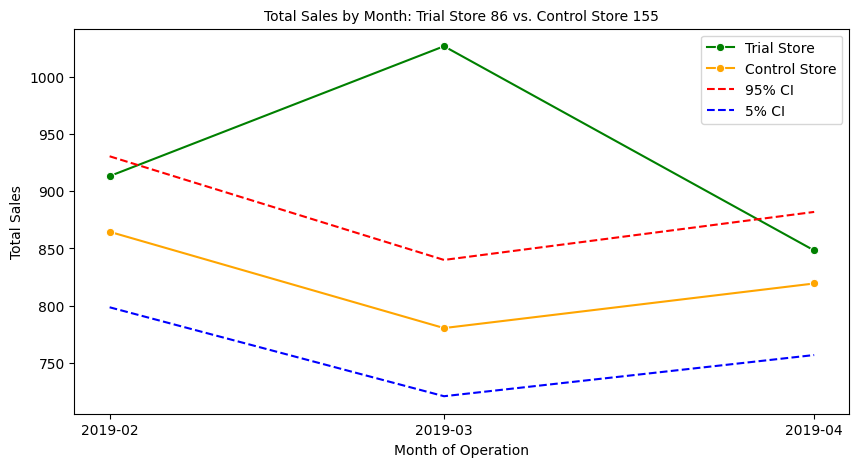

In [100]:
plt.figure(figsize=(10, 5))

# Line chart for Trial and Control Sales
sns.lineplot(data=trialAssessment[trialAssessment["Store_type"] == "Trial"], 
             x="TransactionMonth", y="TotalSales", color="green", marker='o', label="Trial Store")

sns.lineplot(data=trialAssessment[trialAssessment["Store_type"] == "Control"], 
             x="TransactionMonth", y="ScaledControlSales", color="orange", marker='o', label="Control Store")

# Line chart for 95% and 5% CI
sns.lineplot(data=trialAssessment[trialAssessment["Store_type"] == "Control 95% CI"], 
             x="TransactionMonth", y="ScaledControlSales", color="red", linestyle="dashed", label="95% CI")

sns.lineplot(data=trialAssessment[trialAssessment["Store_type"] == "Control 5% CI"], 
             x="TransactionMonth", y="ScaledControlSales", color="blue", linestyle="dashed", label="5% CI")

plt.xlabel("Month of Operation")
plt.ylabel("Total Sales")
plt.title(f"Total Sales by Month: Trial Store {trial_store} vs. Control Store {control_store_nbr}", fontsize = 10)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(trialAssessment["TransactionMonth"].unique())
plt.legend()
plt.show()

##### Insights:
-  The Trial store sales for Feb stayed within the 95th confidence interval, so no meaningful difference, but for March the sales for Trial store are very well above the threshold showing significant increase, however in April the sales have dropped below threshold line suggesting the effect didn't last long.

##### Analyzing Customer Counts

In [101]:
# Get total pre-trial customer counts for Trial and Control Stores
trial_store_pre_customers = pre_trial_sales[(pre_trial_sales["STORE_NBR"] == trial_store) & (pre_trial_sales["YEARMONTH"] < 201902)]["nCustomers"].sum()

control_store_pre_customers = pre_trial_sales[(pre_trial_sales["STORE_NBR"] == control_store_nbr) & (pre_trial_sales["YEARMONTH"] < 201902)]["nCustomers"].sum()

# compute Scaling Factor
scalingFactorForControlCust = trial_store_pre_customers / control_store_pre_customers
print("Scaling Factor for Control Store:", scalingFactorForControlCust)

Scaling Factor for Control Store: 1.0


In [102]:
# apply Scaling Factor to Control Store
measureOverTimeCusts = measure_over_time_sales.copy()
measureOverTimeCusts.loc[measureOverTimeCusts["STORE_NBR"] == control_store_nbr, "ScaledControlCustomers"] = measureOverTimeCusts["nCustomers"] * scalingFactorForControlCust

In [103]:
measureOverTimeCusts.head(3)

,STORE_NBR,YEARMONTH,TotalSales,nCustomers,nTransactions,nChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,ScaledControlSales,ScaledControlCustomers
0,1,201807,206.9,49,52,62,1.061224,1.192308,3.337097,NaN,NaN
1,1,201808,176.1,42,43,54,1.023810,1.255814,3.261111,NaN,NaN
2,1,201809,278.8,59,62,75,1.050847,1.209677,3.717333,NaN,NaN


In [104]:
# calculate the percentage differnce
percentage_diff_customers = measureOverTimeCusts.copy()

# merge trial store and scaled control customers
percentage_diff_customers = measureOverTimeCusts[(measureOverTimeCusts["STORE_NBR"] == trial_store) | 
                                          (measureOverTimeCusts["STORE_NBR"] == control_store_nbr)
                                         ][["YEARMONTH", "STORE_NBR", "nCustomers", "ScaledControlCustomers"]]

In [105]:
percentage_diff_customers.head()

,YEARMONTH,STORE_NBR,nCustomers,ScaledControlCustomers
977,201807,86,99,NaN
978,201808,86,94,NaN
979,201809,86,103,NaN
980,201810,86,109,NaN
981,201811,86,100,NaN


In [106]:
percentage_diff_customers = percentage_diff_customers.pivot(index="YEARMONTH", columns="STORE_NBR", values =
                                                            ["nCustomers", "ScaledControlCustomers"]).reset_index()

In [107]:
percentage_diff_customers.columns = ['YEARMONTH', 'TrialCustomers', 'ControlCustomers', 'TrialScaledCustomers', 'ScaledControlCustomers']
percentage_diff_customers = percentage_diff_customers.drop(columns=['TrialScaledCustomers'])

In [108]:
# compute percentage difference
percentage_diff_customers["PercentageDiff"] = ((percentage_diff_customers["TrialCustomers"] - percentage_diff_customers["ScaledControlCustomers"]) / 
                                               ((percentage_diff_customers["TrialCustomers"] + percentage_diff_customers["ScaledControlCustomers"]) / 2))

In [109]:
percentage_diff_customers.head()

,YEARMONTH,TrialCustomers,ControlCustomers,ScaledControlCustomers,PercentageDiff
0,201807,99.0,101.0,101.0,-0.020000
1,201808,94.0,91.0,91.0,0.032432
2,201809,103.0,103.0,103.0,0.000000
3,201810,109.0,108.0,108.0,0.009217
4,201811,100.0,101.0,101.0,-0.009950


In [110]:
# calculate the standard deviation of the percentage difference before the trial
pre_trial_std_dev_customers = percentage_diff_customers[percentage_diff_customers["YEARMONTH"] < 201902]["PercentageDiff"].std()
print("Standard Deviation of Percentage Difference (Pre-Trial):", pre_trial_std_dev_customers)

Standard Deviation of Percentage Difference (Pre-Trial): 0.019079249324511043


In [111]:
# compute T-values for Trial Period to check for significant change
percentage_diff_customers["tValue"] = percentage_diff_customers["PercentageDiff"] / pre_trial_std_dev_customers

In [112]:
# lets decide significance level
from scipy.stats import t

degrees_of_freedom = 6  
t_critical_customers = t.ppf(0.95, degrees_of_freedom)
print("95th Percentile of t-distribution (Customers):", t_critical_customers)

95th Percentile of t-distribution (Customers): 1.9431802805153018


In [113]:
# check if the trial period's t-values exceed the critical value
percentage_diff_customers["Significance"] = percentage_diff_customers["tValue"].apply(lambda x: "Significant" if 
                                                                                      x > t_critical_customers else "Not Significant")
# filter trial months 
trial_results_customers = percentage_diff_customers[(percentage_diff_customers["YEARMONTH"] >= 201902) & 
                                                    (percentage_diff_customers["YEARMONTH"] <= 201904)]
trial_results_customers[["YEARMONTH", "PercentageDiff", "tValue", "Significance"]]

,YEARMONTH,PercentageDiff,tValue,Significance
7,201902,0.118812,6.227283,Significant
8,201903,0.200957,10.532749,Significant
9,201904,0.058824,3.083116,Significant


##### Insights:
-  Feb 2019 : The trial store had 11.88% more customers than the scaled control store. With a t-value of 6.23, this increase was statistically significant, this result strongly rejects the null hypothesis.
-  March 2019 : Customer count at the trial store jumped even further 20.10% higher than the control. The t-value of 10.53 confirmed this as a highly significant result, showing a strong positive effect of the trial.
-  April 2019 : The sales increase was smaller at 5.88%, the t-value (3.08) still exceeded the critical threshold, meaning the change remained statistically significant. 
-  For Trial store 86 throughout all three trial months, the customer counts at the trial store consistently exceeded those of the scaled control store in a way that could not be explained by chance alone.

In [114]:
measure_over_time_cust = measureOverTimeCusts.copy()
measure_over_time_cust["Store_type"] = measure_over_time_cust["STORE_NBR"].apply(lambda x: "Trial" if x == trial_store
                                                                                else "Control" if x == control_store_nbr else None)

# filter only the Control and Trial Store
pastCusts = measure_over_time_cust[measure_over_time_cust["Store_type"].notna()].copy()
pastCusts['Store_type'].unique()

array(['Trial', 'Control'], dtype=object)

In [115]:
pastCusts.head(3)

,STORE_NBR,YEARMONTH,TotalSales,nCustomers,nTransactions,nChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,ScaledControlSales,ScaledControlCustomers,Store_type
977,86,201807,892.20,99,126,251,1.272727,1.992063,3.554582,NaN,NaN,Trial
978,86,201808,764.05,94,110,215,1.170213,1.954545,3.553721,NaN,NaN,Trial
979,86,201809,914.60,103,128,258,1.242718,2.015625,3.544961,NaN,NaN,Trial


We need to create two extra versions of the Control Store’s customer counts:
-  Control 95% Confidence Interval → Upper Bound (Control Customer × (1 + 2 × Std Dev))
-  Control 5% Confidence Interval → Lower Bound (Control Customer × (1 - 2 × Std Dev))

In [116]:
# create upper bound
pastCusts_Control95 = pastCusts[pastCusts["Store_type"] == "Control"].copy()
pastCusts_Control95["ScaledControlCustomers"] *= (1 + 2 * pre_trial_std_dev_customers)
pastCusts_Control95["Store_type"] = "Control 95% CI"

# create Lower Bound 
pastCusts_Control5 = pastCusts[pastCusts["Store_type"] == "Control"].copy()
pastCusts_Control5["ScaledControlCustomers"] *= (1 - 2 * pre_trial_std_dev_customers)
pastCusts_Control5["Store_type"] = "Control 5% CI"

# concatenate all datasets
trial_Assessment = pd.concat([pastCusts, pastCusts_Control95, pastCusts_Control5])

trial_Assessment = trial_Assessment[trial_Assessment["YEARMONTH"].isin([201902, 201903, 201904])]

In [117]:
# TransactionMonth in datetime format
trial_Assessment["TransactionMonth"] = pd.to_datetime(trial_Assessment["YEARMONTH"].astype(str), format="%Y%m")

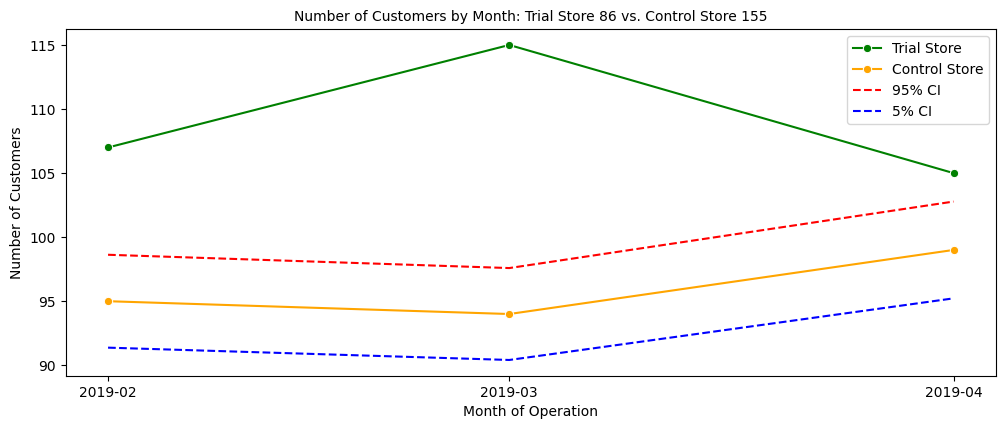

In [118]:

plt.figure(figsize=(12, 4.5))

# Line chart for Trial and Control store
sns.lineplot(data=trial_Assessment[trial_Assessment["Store_type"] == "Trial"], 
             x="TransactionMonth", y="nCustomers", color="green", marker='o', label="Trial Store")

sns.lineplot(data=trial_Assessment[trial_Assessment["Store_type"] == "Control"], 
             x="TransactionMonth", y="ScaledControlCustomers", color="orange", marker='o', label="Control Store")

# Line chart for 95% and 5% CI 
sns.lineplot(data=trial_Assessment[trial_Assessment["Store_type"] == "Control 95% CI"], 
             x="TransactionMonth", y="ScaledControlCustomers", color="red", linestyle="dashed", label="95% CI")

sns.lineplot(data=trial_Assessment[trial_Assessment["Store_type"] == "Control 5% CI"], 
             x="TransactionMonth", y="ScaledControlCustomers", color="blue", linestyle="dashed", label="5% CI")

plt.xlabel("Month of Operation")
plt.ylabel("Number of Customers")
plt.title(f"Number of Customers by Month: Trial Store {trial_store} vs. Control Store {control_store_nbr}", fontsize = 10)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(trial_Assessment["TransactionMonth"].unique())
plt.legend()
plt.show()

##### Insights: 
-  For all three month of trial period, the Trial store consistently exceeded the 95% confidence interval, specifically in March.

#### for trial store 88

In [119]:
# define the trial store number
trial_store = 88

In [120]:
# compute correlation score
corr_nSales = calculate_correlation(pre_trial_data, "TotalSales",trial_store)
corr_nCustomers = calculate_correlation(pre_trial_data, "nCustomers", trial_store)

In [121]:
# compute magnitute similarity score
magnitude_nSales = calculate_magnitude_distance(pre_trial_data, "TotalSales", trial_store)
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_data, "nCustomers", trial_store)

In [122]:
# merge correlation and magnitude scores for each metric separately
score_nSales = corr_nSales.merge(magnitude_nSales, on =["Trial Store", "Control Store"])
score_nCustomers = corr_nCustomers.merge(magnitude_nCustomers, on=["Trial Store", "Control Store"])

In [123]:
# combine the correlation and magnitude similarity for each metric by taking a weighted average
corr_weight = 0.5 

score_nSales['scoreNSales'] = (corr_weight * score_nSales['Correlation'] + (1 - corr_weight) * score_nSales["MagMeasure"])
score_nCustomers['scoreNCust'] = (corr_weight * score_nCustomers['Correlation'] + (1 - corr_weight) * score_nCustomers["MagMeasure"])

In [124]:
score_nSales.head(3)

,Trial Store,Control Store,Correlation,MagMeasure,scoreNSales
0,88,1,0.813636,0.143453,0.478544
1,88,2,-0.067927,0.116355,0.024214
2,88,3,-0.507847,0.806064,0.149108


In [125]:
score_nCustomers.head(3)

,Trial Store,Control Store,Correlation,MagMeasure,scoreNCust
0,88,1,0.305334,0.353668,0.329501
1,88,2,-0.452379,0.302289,-0.075045
2,88,3,0.522884,0.849307,0.686095


In [126]:
# merge the Sales and Customers scores into one table
score_control = score_nSales.merge(score_nCustomers, on=["Trial Store", "Control Store"], suffixes=("_Sales", "_Cust"))

In [127]:
# take simple average of both the scores to get a final ranking
score_control["finalControlScore"] = (0.5 * score_control["scoreNSales"] +  0.5 * score_control["scoreNCust"])

In [128]:
score_control.head(3)

,Trial Store,Control Store,Correlation_Sales,MagMeasure_Sales,scoreNSales,Correlation_Cust,MagMeasure_Cust,scoreNCust,finalControlScore
0,88,1,0.813636,0.143453,0.478544,0.305334,0.353668,0.329501,0.404023
1,88,2,-0.067927,0.116355,0.024214,-0.452379,0.302289,-0.075045,-0.025415
2,88,3,-0.507847,0.806064,0.149108,0.522884,0.849307,0.686095,0.417602


In [129]:
# pick the store with the highest final score
best_control_store =  score_control.sort_values(by = 'finalControlScore', ascending = False)
best_control_store.head()

,Trial Store,Control Store,Correlation_Sales,MagMeasure_Sales,scoreNSales,Correlation_Cust,MagMeasure_Cust,scoreNCust,finalControlScore
224,88,237,0.308479,0.960010,0.634245,0.947326,0.994284,0.970805,0.802525
169,88,178,0.731857,0.698766,0.715311,0.939466,0.826829,0.883148,0.79923
65,88,69,0.450029,0.710866,0.580447,0.815792,0.875175,0.845483,0.712965
105,88,113,0.495763,0.685601,0.590682,0.862632,0.789439,0.826036,0.708359
191,88,201,0.492735,0.876633,0.684684,0.511302,0.92677,0.719036,0.70186


In [130]:
# pick the top one
control_store = best_control_store.groupby("Trial Store").first()
control_store

,Control Store,Correlation_Sales,MagMeasure_Sales,scoreNSales,Correlation_Cust,MagMeasure_Cust,scoreNCust,finalControlScore
Trial Store,,,,,,,,
88,237,0.308479,0.96001,0.634245,0.947326,0.994284,0.970805,0.802525


In [131]:
pre_trial_sales = store_metrics[store_metrics["YEARMONTH"] < 201902].copy()
# extract the control store number
control_store_nbr = control_store.loc[trial_store, "Control Store"]
pre_trial_sales["Store_type"] = pre_trial_sales["STORE_NBR"].map(lambda x: "Trial" if x == trial_store else 
                                                                 "Control" if x == control_store_nbr else None)

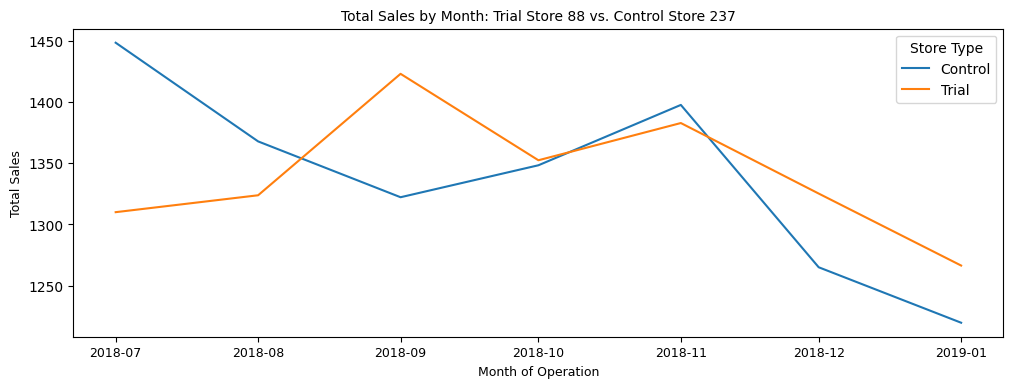

In [132]:
# Plot the Sales Trends
sales_trends = pre_trial_sales.dropna(subset=["Store_type"]).groupby(["YEARMONTH", "Store_type"])["TotalSales"].mean().reset_index()
sales_trends["TransactionMonth"] = pd.to_datetime(sales_trends["YEARMONTH"].astype(str), format="%Y%m")

plt.figure(figsize=(12, 4))
sns.lineplot(data=sales_trends, x="TransactionMonth", y="TotalSales", hue="Store_type")
plt.xlabel("Month of Operation", fontsize = 9)
plt.ylabel("Total Sales", fontsize = 9)
plt.title(f"Total Sales by Month: Trial Store {trial_store} vs. Control Store {control_store_nbr}", fontsize = 10)
plt.xticks(fontsize =9)
plt.legend(title="Store Type")
plt.show()

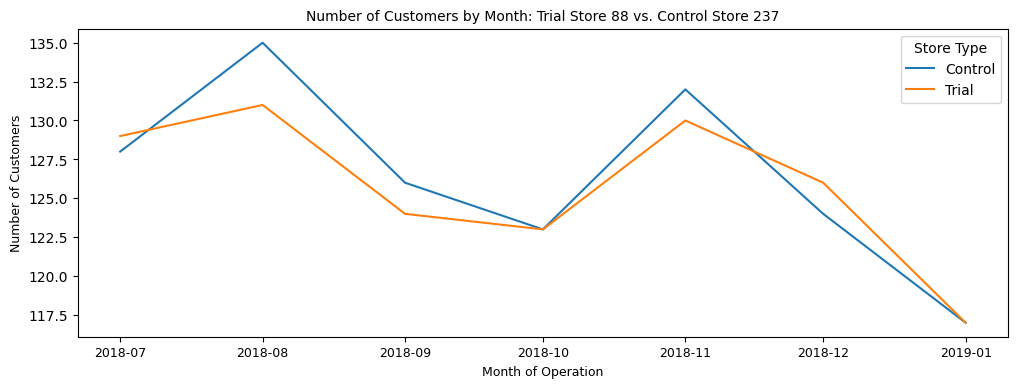

In [133]:
# plotting customer trends
customer_trends = pre_trial_sales.dropna(subset=["Store_type"]).groupby(["YEARMONTH", "Store_type"])["nCustomers"].mean().reset_index()
customer_trends["TransactionMonth"] = pd.to_datetime(customer_trends["YEARMONTH"].astype(str), format ="%Y%m")

plt.figure(figsize=(12, 4))
sns.lineplot(data=customer_trends, x="TransactionMonth", y="nCustomers", hue="Store_type")
plt.xlabel("Month of Operation", fontsize = 9)
plt.ylabel("Number of Customers", fontsize = 9)
plt.title(f"Number of Customers by Month: Trial Store {trial_store} vs. Control Store {control_store_nbr}", fontsize = 10)
plt.xticks(fontsize =9)
plt.legend(title="Store Type")
plt.show()

But before we compare the sales trends of the Trial Store and the Control Store, we need to adjust for pre-existing differences in their sales levels.

In [134]:
# get pre-trial total sales 
trial_store_pre_sales = pre_trial_sales[(pre_trial_sales["STORE_NBR"] == trial_store) & (pre_trial_sales["YEARMONTH"] < 201902)]["TotalSales"].sum()
control_store_pre_sales = pre_trial_sales[(pre_trial_sales["STORE_NBR"] == control_store_nbr) & (pre_trial_sales["YEARMONTH"] < 201902)]["TotalSales"].sum()

In [135]:
scaling_factor = trial_store_pre_sales/control_store_pre_sales
print("Scaling Factor for Control Store:", scaling_factor)

Scaling Factor for Control Store: 1.001558330664959


In [136]:
# adjust the control store sales
measure_over_time_sales = store_metrics.copy()

# scale control store sales
measure_over_time_sales.loc[measure_over_time_sales["STORE_NBR"] == control_store_nbr, "ScaledControlSales"] = measure_over_time_sales["TotalSales"] * scaling_factor

In [137]:
measure_over_time_sales.head()

,STORE_NBR,YEARMONTH,TotalSales,nCustomers,nTransactions,nChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,ScaledControlSales
0,1,201807,206.9,49,52,62,1.061224,1.192308,3.337097,NaN
1,1,201808,176.1,42,43,54,1.023810,1.255814,3.261111,NaN
2,1,201809,278.8,59,62,75,1.050847,1.209677,3.717333,NaN
3,1,201810,188.1,44,45,58,1.022727,1.288889,3.243103,NaN
4,1,201811,192.6,46,47,57,1.021739,1.212766,3.378947,NaN


In [138]:
# calculate the percentage difference
percentage_diff = measure_over_time_sales.copy()

In [139]:
# merge trial store sales and scaled control sales
percentage_diff = measure_over_time_sales[(measure_over_time_sales["STORE_NBR"] == trial_store) | 
                                          (measure_over_time_sales["STORE_NBR"] == control_store_nbr)
                                         ][["YEARMONTH", "STORE_NBR", "TotalSales", "ScaledControlSales"]]

In [140]:
# get separate columns for Trial and Control Sales
percentage_diff = percentage_diff.pivot(index="YEARMONTH", columns="STORE_NBR", values=["TotalSales", "ScaledControlSales"]).reset_index()

percentage_diff.columns = ['YEARMONTH', 'TrialSales', 'ControlSales', 'TrialScaledSales', 'ScaledControlSales']
percentage_diff = percentage_diff.drop(columns=['TrialScaledSales'])

In [141]:
# compute percentage difference
percentage_diff["PercentageDiff"] = ((percentage_diff["TrialSales"] - percentage_diff["ScaledControlSales"]) / 
                                     ((percentage_diff["TrialSales"] + percentage_diff["ScaledControlSales"]) / 2))

In [142]:
# calculate the standard deviation of the percentage difference before the trial
pre_trial_std_dev = percentage_diff[percentage_diff["YEARMONTH"] < 201902]["PercentageDiff"].std()
print("Standard Deviation of Percentage Difference (Pre-Trial):", pre_trial_std_dev)

Standard Deviation of Percentage Difference (Pre-Trial): 0.05800196264587616


In [143]:
# compute T-values for Trial period
percentage_diff["tValue"] = percentage_diff["PercentageDiff"] / pre_trial_std_dev

In [144]:
percentage_diff

,YEARMONTH,TrialSales,ControlSales,ScaledControlSales,PercentageDiff,tValue
0,201807,1310.00,1448.4,1450.657086,-0.101901,-1.756857
1,201808,1323.80,1367.8,1369.931485,-0.034251,-0.590514
2,201809,1423.00,1322.2,1324.260425,0.071882,1.239307
3,201810,1352.40,1348.3,1350.401097,0.001479,0.025501
4,201811,1382.80,1397.6,1399.777923,-0.012203,-0.210390
5,201812,1325.20,1265.0,1266.971288,0.044927,0.774570
6,201901,1266.40,1219.7,1221.600696,0.036012,0.620881
7,201902,1370.20,1404.8,1406.989143,-0.026494,-0.456774
8,201903,1477.20,1208.2,1210.082775,0.198801,3.427487
9,201904,1439.40,1204.6,1206.477165,0.176065,3.035496


In [145]:
# decide significance level
from scipy.stats import t

# get the 95th percentile of the t-distribution
degrees_of_freedom = 6
t_critical = t.ppf(0.95, degrees_of_freedom)
print("95th Percentile of t-distribution:", t_critical)

95th Percentile of t-distribution: 1.9431802805153018


In [146]:
# check if the trial period's t-values exceed the critical value
percentage_diff["Significance"] = percentage_diff["tValue"].apply(
    lambda x: "Significant" if x > t_critical else "Not Significant")

# filter only trial months 
trial_results = percentage_diff[(percentage_diff["YEARMONTH"] >= 201902) & (percentage_diff["YEARMONTH"] <= 201904)]
trial_results[["YEARMONTH", "PercentageDiff", "tValue", "Significance"]]

,YEARMONTH,PercentageDiff,tValue,Significance
7,201902,-0.026494,-0.456774,Not Significant
8,201903,0.198801,3.427487,Significant
9,201904,0.176065,3.035496,Significant


##### Insights
-  February 2019 : Sales at the trial store were -2.65% lower than the scaled control store. The t-value was -0.46, well below the threshold for significance. 
-  March 2019 : A strong uplift in sales with +19.88% increase compared to the scaled control store. The t-value of 3.43 was well above the critical value, indicating a statistically significant increase.
-  April 2019 : Still an increase in sales with +17.61% over the control store. The t-value of 3.04 shows significance, all this suggests the trial store sustained its growth.
-  Trial store 88 results highlight a clear positive impact of the trial on sales performance, with March at the peak of the effect.

##### Let us visualize if the trial actually worked by looking at a line graph

In [147]:
measureOverTimeSales = measure_over_time_sales.copy()
measureOverTimeSales["Store_type"] = measureOverTimeSales["STORE_NBR"].apply(lambda x: "Trial" if x == trial_store 
                                                                             else "Control" if x == control_store_nbr else None)
# filter only the Control and Trial Store
pastSales = measureOverTimeSales[measureOverTimeSales["Store_type"].notna()].copy()
pastSales['Store_type'].unique()

array(['Trial', 'Control'], dtype=object)

In [148]:
pastSales.head(3)

,STORE_NBR,YEARMONTH,TotalSales,nCustomers,nTransactions,nChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,ScaledControlSales,Store_type
1001,88,201807,1310.0,129,153,306,1.186047,2.000000,4.281046,NaN,Trial
1002,88,201808,1323.8,131,158,303,1.206107,1.917722,4.368977,NaN,Trial
1003,88,201809,1423.0,124,157,318,1.266129,2.025478,4.474843,NaN,Trial


We need to create two extra versions of the Control Store’s sales:
-  Control 95% Confidence Interval → Upper Bound (Control Sales × (1 + 2 × Std Dev))
-  Control 5% Confidence Interval → Lower Bound (Control Sales × (1 - 2 × Std Dev))

In [149]:
# create Upper Bound 
pastSales_Control95 = pastSales[pastSales["Store_type"] == "Control"].copy()
control_sales_mean = pastSales_Control95["ScaledControlSales"].mean()
pastSales_Control95["ScaledControlSales"] = pastSales_Control95["ScaledControlSales"] * (1 + 2 * pre_trial_std_dev)
pastSales_Control95["Store_type"] = "Control 95% CI"

# create Lower Bound 
pastSales_Control5 = pastSales[pastSales["Store_type"] == "Control"].copy()
pastSales_Control5["ScaledControlSales"] = pastSales_Control5["ScaledControlSales"] * (1 - 2 * pre_trial_std_dev)
pastSales_Control5["Store_type"] = "Control 5% CI"

# concatenate all datasets
trialAssessment = pd.concat([pastSales, pastSales_Control95, pastSales_Control5])

In [150]:
trialAssessment = trialAssessment[trialAssessment["YEARMONTH"].isin([201902, 201903, 201904])]

In [151]:
# TransactionMonth in datetime format
trialAssessment["TransactionMonth"] = pd.to_datetime(trialAssessment["YEARMONTH"].astype(str), format="%Y%m")

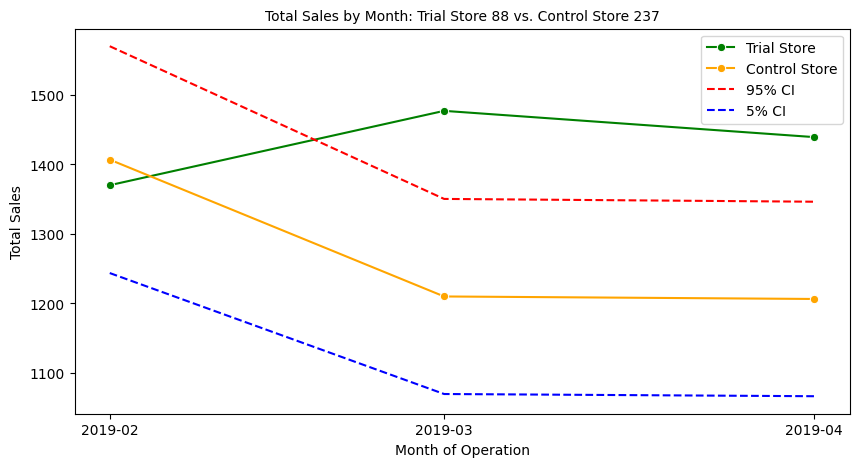

In [152]:
plt.figure(figsize=(10, 5))

# Line chart for Trial and Control Sales
sns.lineplot(data=trialAssessment[trialAssessment["Store_type"] == "Trial"], 
             x="TransactionMonth", y="TotalSales", color="green", marker='o', label="Trial Store")

sns.lineplot(data=trialAssessment[trialAssessment["Store_type"] == "Control"], 
             x="TransactionMonth", y="ScaledControlSales", color="orange", marker='o', label="Control Store")

# Line chart for 95% and 5% CI
sns.lineplot(data=trialAssessment[trialAssessment["Store_type"] == "Control 95% CI"], 
             x="TransactionMonth", y="ScaledControlSales", color="red", linestyle="dashed", label="95% CI")

sns.lineplot(data=trialAssessment[trialAssessment["Store_type"] == "Control 5% CI"], 
             x="TransactionMonth", y="ScaledControlSales", color="blue", linestyle="dashed", label="5% CI")

plt.xlabel("Month of Operation")
plt.ylabel("Total Sales")
plt.title(f"Total Sales by Month: Trial Store {trial_store} vs. Control Store {control_store_nbr}", fontsize = 10)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(trialAssessment["TransactionMonth"].unique())
plt.legend()
plt.show()

##### Insights:
-  For Feb 2019 the sales were slightly below and within the confidence range, but for March and April the sales are above the 95% confidence line, showing strong and meaningful boost due to the trial.

##### Analyzing Customer Counts

In [153]:
# get total pre-trial customer counts for Trial and Control Stores
trial_store_pre_customers = pre_trial_sales[(pre_trial_sales["STORE_NBR"] == trial_store) & (pre_trial_sales["YEARMONTH"] < 201902)]["nCustomers"].sum()

control_store_pre_customers = pre_trial_sales[(pre_trial_sales["STORE_NBR"] == control_store_nbr) & (pre_trial_sales["YEARMONTH"] < 201902)]["nCustomers"].sum()

# compute Scaling Factor
scalingFactorForControlCust = trial_store_pre_customers / control_store_pre_customers
print("Scaling Factor for Control Store:", scalingFactorForControlCust)

Scaling Factor for Control Store: 0.9943502824858758


In [154]:
# apply Scaling Factor to Control Store
measureOverTimeCusts = measure_over_time_sales.copy()
measureOverTimeCusts.loc[measureOverTimeCusts["STORE_NBR"] == control_store_nbr, "ScaledControlCustomers"] = measureOverTimeCusts["nCustomers"] * scalingFactorForControlCust

In [155]:
measureOverTimeCusts.head(3)

,STORE_NBR,YEARMONTH,TotalSales,nCustomers,nTransactions,nChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,ScaledControlSales,ScaledControlCustomers
0,1,201807,206.9,49,52,62,1.061224,1.192308,3.337097,NaN,NaN
1,1,201808,176.1,42,43,54,1.023810,1.255814,3.261111,NaN,NaN
2,1,201809,278.8,59,62,75,1.050847,1.209677,3.717333,NaN,NaN


In [156]:
# calculate the percentage differnce
percentage_diff_customers = measureOverTimeCusts.copy()

# merge trial store and scaled control customers
percentage_diff_customers = measureOverTimeCusts[(measureOverTimeCusts["STORE_NBR"] == trial_store) | 
                                          (measureOverTimeCusts["STORE_NBR"] == control_store_nbr)
                                         ][["YEARMONTH", "STORE_NBR", "nCustomers", "ScaledControlCustomers"]]

In [157]:
percentage_diff_customers.head()

,YEARMONTH,STORE_NBR,nCustomers,ScaledControlCustomers
1001,201807,88,129,NaN
1002,201808,88,131,NaN
1003,201809,88,124,NaN
1004,201810,88,123,NaN
1005,201811,88,130,NaN


In [158]:
percentage_diff_customers = percentage_diff_customers.pivot(index="YEARMONTH", columns="STORE_NBR", values =
                                                            ["nCustomers", "ScaledControlCustomers"]).reset_index()

In [159]:
percentage_diff_customers.columns = ['YEARMONTH', 'TrialCustomers', 'ControlCustomers', 'TrialScaledCustomers', 'ScaledControlCustomers']
percentage_diff_customers = percentage_diff_customers.drop(columns=['TrialScaledCustomers'])

In [160]:
# compute percentage difference
percentage_diff_customers["PercentageDiff"] = ((percentage_diff_customers["TrialCustomers"] - percentage_diff_customers["ScaledControlCustomers"]) / 
                                               ((percentage_diff_customers["TrialCustomers"] + percentage_diff_customers["ScaledControlCustomers"]) / 2))

In [161]:
percentage_diff_customers.head()

,YEARMONTH,TrialCustomers,ControlCustomers,ScaledControlCustomers,PercentageDiff
0,201807,129.0,128.0,127.276836,0.013448
1,201808,131.0,135.0,134.237288,-0.024411
2,201809,124.0,126.0,125.288136,-0.010335
3,201810,123.0,123.0,122.305085,0.005666
4,201811,130.0,132.0,131.254237,-0.009602


In [162]:
# calculate the standard deviation of the percentage difference before the trial
pre_trial_std_dev_customers = percentage_diff_customers[percentage_diff_customers["YEARMONTH"] < 201902]["PercentageDiff"].std()
print("Standard Deviation of Percentage Difference (Pre-Trial):", pre_trial_std_dev_customers)

Standard Deviation of Percentage Difference (Pre-Trial): 0.01585697133794392


In [163]:
# compute T-values for Trial Period to check for significant change
percentage_diff_customers["tValue"] = percentage_diff_customers["PercentageDiff"] / pre_trial_std_dev_customers

In [164]:
# lets get significance level
from scipy.stats import t

degrees_of_freedom = 6  
t_critical_customers = t.ppf(0.95, degrees_of_freedom)
print("95th Percentile of t-distribution (Customers):", t_critical_customers)

95th Percentile of t-distribution (Customers): 1.9431802805153018


In [165]:
# check if the trial period's t-values exceed the critical value
percentage_diff_customers["Significance"] = percentage_diff_customers["tValue"].apply(lambda x: "Significant" if 
                                                                                      x > t_critical_customers else "Not Significant")
# filter trial months 
trial_results_customers = percentage_diff_customers[(percentage_diff_customers["YEARMONTH"] >= 201902) & 
                                                    (percentage_diff_customers["YEARMONTH"] <= 201904)]
trial_results_customers[["YEARMONTH", "PercentageDiff", "tValue", "Significance"]]

,YEARMONTH,PercentageDiff,tValue,Significance
7,201902,-0.010335,-0.651733,Not Significant
8,201903,0.124222,7.833900,Significant
9,201904,0.070175,4.425526,Significant


 ##### Insights:
 -  Feb 2019 : Number of customer at the trial store were actually 1.03% lower than those at the scaled control store. With a t-value of -0.65, this difference was not statistically significant.
 -  March 2019 : Customer counts at the trial store rose by 12.42% compared to the control. The t-value shot up to 7.83, clearly surpassing the threshold for statistical significance.
 -  April 2019 : The upward trend continued with a 7.02% increase in customer visits over the control. A t-value of 4.43 once again indicated a statistically significant improvement, showing that the trial store was consistently drawing more customers.
 -  Trial store 88 customer analysis results highlight a clear and positive trial effect on customer engagement, especially from the second month onward.

In [166]:
measure_over_time_cust = measureOverTimeCusts.copy()
measure_over_time_cust["Store_type"] = measure_over_time_cust["STORE_NBR"].apply(lambda x: "Trial" if x == trial_store
                                                                                else "Control" if x == control_store_nbr else None)

# filter only the Control and Trial Store
pastCusts = measure_over_time_cust[measure_over_time_cust["Store_type"].notna()].copy()
pastCusts['Store_type'].unique()

array(['Trial', 'Control'], dtype=object)

In [167]:
pastCusts.head(3)

,STORE_NBR,YEARMONTH,TotalSales,nCustomers,nTransactions,nChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,ScaledControlSales,ScaledControlCustomers,Store_type
1001,88,201807,1310.0,129,153,306,1.186047,2.000000,4.281046,NaN,NaN,Trial
1002,88,201808,1323.8,131,158,303,1.206107,1.917722,4.368977,NaN,NaN,Trial
1003,88,201809,1423.0,124,157,318,1.266129,2.025478,4.474843,NaN,NaN,Trial


We need to create two extra versions of the Control Store’s customer counts:
-  Control 95% Confidence Interval → Upper Bound (Control Customer × (1 + 2 × Std Dev))
-  Control 5% Confidence Interval → Lower Bound (Control Customer × (1 - 2 × Std Dev))

In [168]:
# create upper bound
pastCusts_Control95 = pastCusts[pastCusts["Store_type"] == "Control"].copy()
pastCusts_Control95["ScaledControlCustomers"] *= (1 + 2 * pre_trial_std_dev_customers)
pastCusts_Control95["Store_type"] = "Control 95% CI"

# create Lower Bound 
pastCusts_Control5 = pastCusts[pastCusts["Store_type"] == "Control"].copy()
pastCusts_Control5["ScaledControlCustomers"] *= (1 - 2 * pre_trial_std_dev_customers)
pastCusts_Control5["Store_type"] = "Control 5% CI"

# concatenate all datasets
trial_Assessment = pd.concat([pastCusts, pastCusts_Control95, pastCusts_Control5])

trial_Assessment = trial_Assessment[trial_Assessment["YEARMONTH"].isin([201902, 201903, 201904])]

In [169]:
# TransactionMonth in datetime format
trial_Assessment["TransactionMonth"] = pd.to_datetime(trial_Assessment["YEARMONTH"].astype(str), format="%Y%m")

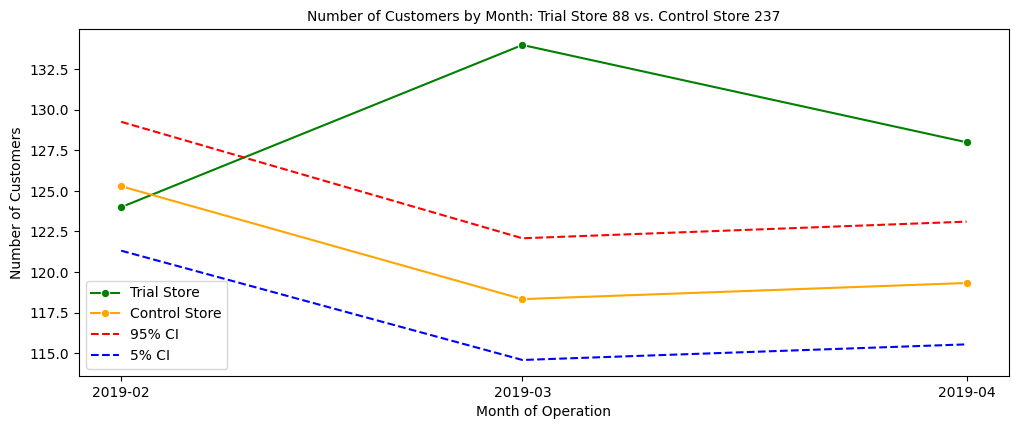

In [170]:

plt.figure(figsize=(12, 4.5))

# Line chart for Trial and Control store
sns.lineplot(data=trial_Assessment[trial_Assessment["Store_type"] == "Trial"], 
             x="TransactionMonth", y="nCustomers", color="green", marker='o', label="Trial Store")

sns.lineplot(data=trial_Assessment[trial_Assessment["Store_type"] == "Control"], 
             x="TransactionMonth", y="ScaledControlCustomers", color="orange", marker='o', label="Control Store")

# Line chart for 95% and 5% CI 
sns.lineplot(data=trial_Assessment[trial_Assessment["Store_type"] == "Control 95% CI"], 
             x="TransactionMonth", y="ScaledControlCustomers", color="red", linestyle="dashed", label="95% CI")

sns.lineplot(data=trial_Assessment[trial_Assessment["Store_type"] == "Control 5% CI"], 
             x="TransactionMonth", y="ScaledControlCustomers", color="blue", linestyle="dashed", label="5% CI")

plt.xlabel("Month of Operation")
plt.ylabel("Number of Customers")
plt.title(f"Number of Customers by Month: Trial Store {trial_store} vs. Control Store {control_store_nbr}", fontsize = 10)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(trial_Assessment["TransactionMonth"].unique())
plt.legend()
plt.show()

##### Insights:
-  Sales in the Trial Store 88 started below the control store sales in February, then jumped above the 95% confidence range in March and April, showing a clear positive impact from the trial during those months.

----------------------------------------

##### Summary:
The trial showed clear success in Stores 77 and 88. Store 77 experienced significant increases in both sales and customer counts starting in March, with even greater gains in April, indicating a strong and sustained trial impact. Store 88 followed a similar pattern after a neutral February, both sales and customer numbers rose sharply in March and stayed elevated in April. Store 86 however, showed a different trend, while customer traffic increased significantly throughout all three months, sales only spiked in March and returned to normal in April

##### Recommendations:
-  Scale trial strategy from Store 77 and 88 to other stores since strong and consistent gains in both customer counts and sales.
-  Refine execution for Store 86 although customer traffic rose, sales did not sustain focus on converting traffic to purchases.
-  Use confidence interval visuals and t-tests in all future trials to easily validate real impact vs random changes.